In [1]:
import os
import zarr
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ds_geo = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr')
XLONG = ds_geo['XLONG'].values
XLAT = ds_geo['XLAT'].values

In [4]:
# fn_area = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_grid_area.zarr'
# ds_area = xr.open_zarr(fn_area)
# area_da = ds_area['c404_area']

In [5]:
varname_verif = ['WRF_T2',]

## CESM-LENS2 energy spectrum compute

In [6]:
R = 6371000.0

def _first_existing_name(names):
    for n in names:
        if (n in ds.data_vars) or (n in ds.coords):
            return n
    return None

def _isel_time_any(da_in, idx):
    # robust: some WRF files use Time vs time inconsistently across vars
    for td in ("time", "Time"):
        if td in da_in.dims:
            return da_in.isel({td: idx})
    return da_in

def _is_meters_coord(c):
    u = str(c.attrs.get("units", "")).lower()
    return (u == "m") or ("meter" in u) or ("metre" in u)

def haversine_radians(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2.0 * np.arcsin(np.sqrt(a))
    return R * c
        
def _estimate_dxdy_m(ds, sn, we, idx_for_latlon):
    """
    Simplified dx/dy estimator:
    - Uses ds['XLAT'] and ds['XLONG'] (degrees) only
    - Computes dx (west_east) and dy (south_north) as median neighbor haversine distances
    """
    if "XLAT" not in ds or "XLONG" not in ds:
        raise ValueError("Expected ds to contain 2-D XLAT and XLONG in degrees.")

    # Grab lat/lon (allow optional time/Time dim even if typically 2-D)
    lat = ds["XLAT"]
    lon = ds["XLONG"]

    # If lat/lon have a time-like dimension, index it
    for td in ("time", "Time"):
        if td in lat.dims:
            lat = lat.isel({td: idx_for_latlon})
        if td in lon.dims:
            lon = lon.isel({td: idx_for_latlon})

    # Ensure (south_north, west_east) order
    lat = lat.transpose(sn, we)
    lon = lon.transpose(sn, we)

    latv = lat.values.astype(np.float64)
    lonv = lon.values.astype(np.float64)
    
    latr = np.deg2rad(latv)
    lonr = np.deg2rad(lonv)
    
    # dx
    dx_grid = haversine_radians(latr[:, :-1], lonr[:, :-1], latr[:, 1:], lonr[:, 1:])
    # dy
    dy_grid = haversine_radians(latr[:-1, :], lonr[:-1, :], latr[1:, :], lonr[1:, :])

    dx = float(np.nanmedian(dx_grid))
    dy = float(np.nanmedian(dy_grid))
    
    return dx, dy

def ZES_compute(
    ds, time_index, var=None,
    dims=("latitude", "longitude"),
    time_dim="time",
    window="hann",
    detrend="none",
    nbins=None,
):
    sn, we = dims

    # Variables to process
    if var is None:
        var_names = list(ds.data_vars)
    elif isinstance(var, (list, tuple, set)):
        var_names = list(var)
    else:
        var_names = [var]

    eligible = []
    skipped = []
    for v in var_names:
        if v not in ds:
            raise KeyError(v)
        da_v = ds[v]
        if not np.issubdtype(da_v.dtype, np.number):
            skipped.append(v)
            continue
        if (time_dim not in da_v.dims) or (sn not in da_v.dims) or (we not in da_v.dims):
            skipped.append(v)
            continue
        if any(d not in (time_dim, sn, we) for d in da_v.dims):
            skipped.append(v)
            continue
        eligible.append(v)

    if not eligible:
        raise ValueError("No eligible variables found to compute spectrum.")

    # Use first eligible var to set up time selection and grids
    da0 = ds[eligible[0]]
    nt = da0.sizes[time_dim]

    start, stop, step = time_index.indices(nt)
    time_indices = list(range(start, stop, step))
    time_coord = ds[time_dim].isel({time_dim: time_indices}) if time_dim in ds.coords else None

    dx, dy = _estimate_dxdy_m(ds, sn, we, time_indices[0])

    sample0 = da0.isel({time_dim: time_indices[0]})
    field0 = sample0.values.astype(np.float64)
    ny, nx = field0.shape

    # Window
    window_l = window.lower() if isinstance(window, str) else "none"
    if window is None or window_l == "none":
        window2d = 1.0
    elif window_l in ("hann", "hanning"):
        wy = np.hanning(ny)
        wx = np.hanning(nx)
        window2d = wy[:, None] * wx[None, :]
        window2d = window2d / np.sqrt(np.mean(window2d**2))  # normalize mean(window^2)=1
    else:
        raise ValueError("window must be None/'none' or 'hann'")

    # k grids
    kx = np.fft.fftfreq(nx, d=dx)  # cycles/m
    ky = np.fft.fftfreq(ny, d=dy)  # cycles/m
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX**2 + KY**2)

    nbins_eff = min(nx, ny) // 2 if nbins is None else int(nbins)
    if nbins_eff < 4:
        raise ValueError(f"nbins too small ({nbins_eff}).")

    kmax = float(np.max(K))
    k_bins = np.linspace(0.0, kmax, nbins_eff + 1)
    dk = np.diff(k_bins)
    k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    valid = k_centers > 0
    k_valid = k_centers[valid]

    wavelength_m = 1.0 / k_valid
    wavelength_km = wavelength_m / 1000.0

    # 2-D shifted coords
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)

    # Detrend plane precompute if needed
    detrend_l = detrend.lower() if detrend is not None else "none"
    if detrend_l == "plane":
        x = np.arange(nx, dtype=np.float64) * dx
        y = np.arange(ny, dtype=np.float64) * dy
        X, Y = np.meshgrid(x, y)
        G = np.stack([X.ravel(), Y.ravel(), np.ones(X.size)], axis=1)
    elif detrend_l in ("mean", "none"):
        G = X = Y = None
    else:
        raise ValueError("detrend must be one of: None/'none', 'mean', 'plane'")

    tvals = time_coord.values

    out_vars = {}

    for v in eligible:
        da = ds[v]

        Ek_list = []
        Elambda_list = []
        P2D_list = []

        for idx in time_indices:
            da_t = da.isel({time_dim: idx}) if time_dim is not None else da
            da_t = da_t.transpose(sn, we)
            field = da_t.values.astype(np.float64)

            if np.isnan(field).any():
                m0 = np.nanmean(field)
                if not np.isfinite(m0):
                    raise ValueError(f"Field at index {idx} is all-NaN; cannot compute spectrum.")
                field = np.where(np.isnan(field), m0, field)

            # detrend
            if detrend_l == "mean":
                field = field - np.mean(field)
            elif detrend_l == "plane":
                m, *_ = np.linalg.lstsq(G, field.ravel(), rcond=None)
                field = field - (m[0] * X + m[1] * Y + m[2])
            elif detrend_l == "none":
                pass

            # window
            field_w = field * window2d

            # FFT and 2-D power
            F = np.fft.fft2(field_w)
            N = nx * ny
            P2D_raw = (np.abs(F) ** 2) / (N ** 2)

            # isotropic spectrum with fixed bins
            power_in_bin, _ = np.histogram(K.ravel(), bins=k_bins, weights=P2D_raw.ravel())
            E_k = power_in_bin / dk
            E_k_valid = E_k[valid]

            E_lambda = E_k_valid / (wavelength_m ** 2)

            Ek_list.append(E_k_valid)
            Elambda_list.append(E_lambda)
            P2D_list.append(np.fft.fftshift(P2D_raw))

        Ek_arr = np.stack(Ek_list, axis=0)            # (t, k)
        Elambda_arr = np.stack(Elambda_list, axis=0)  # (t, k)
        P2D_arr = np.stack(P2D_list, axis=0)          # (t, ky, kx)

        common_attrs = {
            "variable": v,
            "time_indices": [int(i) for i in time_indices],
            "dx_m": float(dx),
            "dy_m": float(dy),
            "k_units": "cycles/m",
            "wavelength_units": "km",
            "window": str(window),
            "detrend": str(detrend),
            "notes": "Computed on the structured grid in projection plane (approx. Cartesian).",
        }

        spec_lambda = xr.DataArray(
            Ek_arr,
            coords={
                time_dim: tvals,
                "wavelength_km": wavelength_km,
                "k_cpm": ("wavelength_km", k_valid),
            },
            dims=(time_dim, "wavelength_km"),
            name=f"{v}",
            attrs=common_attrs | {
                "notes": common_attrs["notes"]
                + " Same E(k) values with wavelength coordinate (lambda=1/k). Not a density per unit wavelength."
            },
        ).sortby("wavelength_km")

        out_vars[spec_lambda.name] = spec_lambda

    out = xr.Dataset(out_vars)
    return out

In [8]:
ds_collection = []

for year in range(2025, 2028):

    fn = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/prog_outputs/opt_CESM_{year}.zarr'
    ds = xr.open_zarr(fn)[varname_verif]

    ds_collection.append(ds)

ds_cesm = xr.concat(ds_collection, dim='time')
ds_cesm = ds_cesm.mean(['member'])
ds_cesm = ds_cesm.rename({
    'south_north': 'latitude',
    'west_east': 'longitude'
})

ds_cesm = ds_cesm.assign_coords(
    XLAT=(('latitude', 'longitude'), XLAT),
    XLONG=(('latitude', 'longitude'), XLONG)
)

ds_zes = ZES_compute(ds_cesm, slice(5, None, 6)) 
ds_zes = ds_zes.load()

ZES = ds_zes.mean(['time'])
ZES_np = ZES['WRF_T2'].values
wavelength = ds_zes['wavelength_km'].values
save_name = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/ZES_FFT_LAM_6H_CESM.npy'
dict_save = {'ZES': ZES_np, 'wavelength': wavelength}
# np.save(save_name, dict_save)

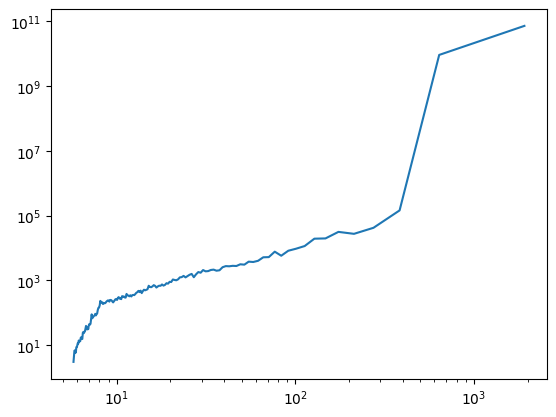

In [19]:
plt.plot(wavelength, ZES_np)
plt.xscale('log')
plt.yscale('log')

In [25]:
varname_verif = ['VAR_2T',]

fn_fmt = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_CESM/CESM_GP_mem{}_{}.zarr'

ds_collection = []
for year in range(2025, 2028):
    ds_mems = []
    for i_mem in range(10):
        fn = fn_fmt.format(i_mem, year)
        ds = xr.open_zarr(fn)[varname_verif]
        ds_mems.append(ds)
        
    ds_year = xr.concat(ds_mems, dim='member')
    ds_year = ds_year.assign_coords(member=np.arange(10))
    ds_collection.append(ds_year)

ds_cesm = xr.concat(ds_collection, dim='time')

ds_cesm = ds_cesm.mean(['member'])
ds_cesm = ds_cesm.rename({
    'south_north': 'latitude',
    'west_east': 'longitude'
})

ds_cesm = ds_cesm.assign_coords(
    XLAT=(('latitude', 'longitude'), XLAT),
    XLONG=(('latitude', 'longitude'), XLONG)
)

skip_CESM_x = slice(None, None, 22) # ~ 0.9 deg
skip_CESM_y = slice(None, None, 30) # ~ 1.2 deg
ds_cesm = ds_cesm.isel(longitude=skip_CESM_x, latitude=skip_CESM_y)

ds_zes = ZES_compute(ds_cesm, slice(0, None)) 
ds_zes = ds_zes.load()

ZES = ds_zes.mean(['time'])
ZES_np = ZES['VAR_2T'].values
wavelength = ds_zes['wavelength_km'].values

save_name = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/ZES_FFT_CESM_LENS.npy'
dict_save = {'ZES': ZES_np, 'wavelength': wavelength}
# np.save(save_name, dict_save)

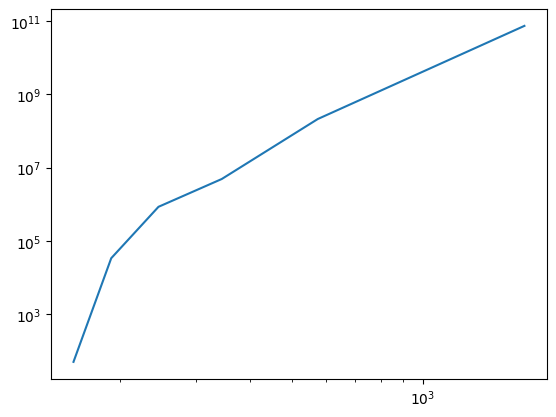

In [27]:
plt.plot(wavelength, ZES_np)
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.save(save_name, dict_save)

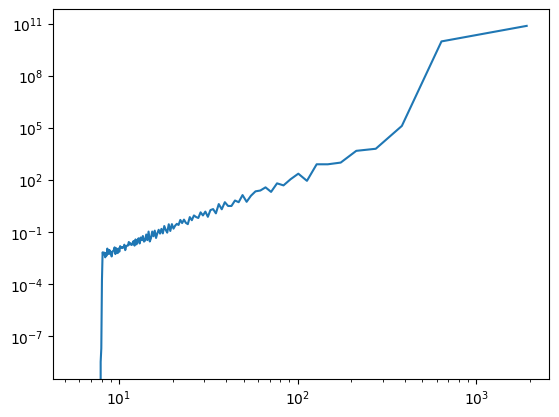

In [24]:
plt.plot(wavelength, ZES_np)
plt.xscale('log')
plt.yscale('log')

### Old Weatherbench2 approach

In [ ]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [7]:
# ds_collection = []

# for year in range(2025, 2028):

#     fn = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/prog_outputs/opt_CESM_{year}.zarr'
#     ds = xr.open_zarr(fn)[varname_verif]

#     ds_collection.append(ds)

# ds_cesm = xr.concat(ds_collection, dim='time')
# ds_cesm = ds_cesm.mean(['member'])
# ds_cesm = ds_cesm.rename({
#     'south_north': 'latitude',
#     'west_east': 'longitude'
# })

# ds_cesm = ds_cesm.assign_coords(
#     XLAT=(('latitude', 'longitude'), XLAT),
#     XLONG=(('latitude', 'longitude'), XLONG)
# )

# ds_cesm = ds_cesm.isel(time=slice(5, None, 6)) # every 6 hour vals to compare with the CESM
# ds_zes = ds_cesm.load()

# calc = ZonalEnergySpectrum('WRF_T2')
# result_fft = calc.compute(ds_zes)
# result_fft = result_fft.clip(min=0)

# ZES = result_fft.mean(['time', 'latitude'])
# ZES_np = np.abs(ZES.values)

# wavelength = result_fft['wavelength'].values
# wavelength_mean = np.abs(wavelength.mean(axis=1))

/glade/work/ksha/miniconda3/envs/credit/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [9]:
# save_name = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/ZES_LAM_6H_CESM.npy'
# dict_save = {'ZES': ZES_np, 'wavelength': wavelength_mean}
# np.save(save_name, dict_save)